# Use PCA analysis on tile embeddings

In this notebook you will work with embedding vectors, with length 100, produced using a trained model and
look at different techniques for understanding how the trained model has made use of this 100-dimensional embedding space. You will work just with embeddings for the *anchor*-tiles in the "study"-part of a dataset comprised of 500 triplets.

The aim is to answer questions like:

1. Are vectors with 100 elements really needed?

   Using PCA analysis you can look at how many principle components are actually needed to explain say 90% of the   variability. This gives an indication of how many of the embedding vectors are independent. How much is needed for 95% variance?
   
   
2. What features has the neural network picked up in the image?

   Taking individual principle components resulting from the PCA analysis look at what are characteristic properties of tiles in the extremes of each dimension.

In [1]:
# load the packages we'll need
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from pathlib import Path
from sklearn.decomposition import PCA

import convml_tt
import convml_tt.interpretation.plots
from convml_tt.data.examples import (
    fetch_example_dataset,
    ExampleData,
    load_pretrained_model,
    PretrainedModel,
)
from convml_tt.utils import get_embeddings
from convml_tt.data.dataset import ImageSingletDataset, TileType
from convml_tt.data.transforms import get_transforms

xr.__version__, convml_tt.__version__, pl.__version__

('2024.2.0', '0.14.1', '1.9.5')

In [2]:
# first we'll download and unpack one of the example datasets bundled with convml-tt
data_path = fetch_example_dataset(dataset=ExampleData.LARGE2000S500)
data_path

  0%|          | 0/1092419466 [00:00<?, ?it/s]

Extracting data/Nx256_s200000.0_N500study_N2000train.tgz to data/


PosixPath('data/Nx256_s200000.0_N500study_N2000train')

In [3]:
# and we'll load a pretrained model (that was trained on true-color RGB composite tiles)
model = load_pretrained_model(pretrained_model=PretrainedModel.FIXED_NORM_STAGE2)

  0%|          | 0/43696025 [00:00<?, ?it/s]

Extracting data/fixednorm-stage-2.tgz to data/
Weights loaded from `data/fixednorm-stage-2.torch.pkl`


In [4]:
# from the dataset we'll just load up the "study" (vs the "training" part) and
# only the "anchor" tiles. The transforms ensure that the RGB components of the
# image tiles are scaled to match how the model was trained (during training
# the transforms will additionally do augmentation of the tiles)
dataset = ImageSingletDataset(
    stage="study",
    data_dir=data_path,
    transform=get_transforms(step="predict", normalize_for_arch=model.base_arch),
    tile_type=TileType.ANCHOR,
)
len(dataset)

500

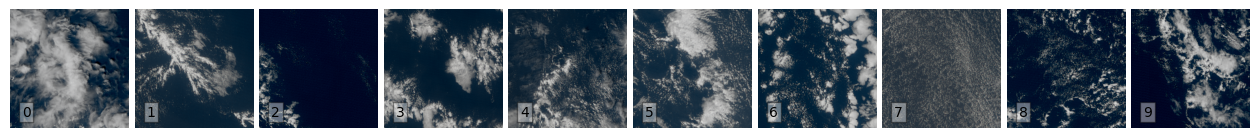

In [5]:
# let's have a look at the dataset, plot 10 random tiles
convml_tt.interpretation.plots.grid_overview(tile_dataset=dataset, points=10)

In [6]:
# produce embeddings with the trained model, we'll save the embeddings to a file
# so you don't have to run this again in case you restart the notebook
# (also you'll need the embedding vectors for the exercises in 1b)

fn = Path("fixednorm-stage-2.emb.nc")
if not fn.exists():
    da_embs = get_embeddings(tile_dataset=dataset, model=model)
    da_embs.to_netcdf(fn)
else:
    da_embs = xr.open_dataarray(fn)

In [7]:
da_embs

<xarray.DataArray (tile_id: 500, emb_dim: 100)> Size: 200kB
[50000 values with dtype=float32]
Coordinates:
  * tile_id  (tile_id) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Dimensions without coordinates: emb_dim
Attributes:
    tile_type:  ANCHOR
    stage:      study
    data_dir:   /home/leifdenby/git-repos/SENSE_convml_tt/notebooks/data/Nx25...

In [8]:
# run PCA analysis with enough components to explains %50 of variance
pca = PCA(n_components=0.50)

# create a numpy array with pca fit
arr_pca = pca.fit_transform(da_embs)

# create an xarray.DataArray to make this array easier to work with
da_embs_pca = xr.DataArray(
    arr_pca,
    dims=("tile_id", "pca_dim"),
    coords=dict(tile_id=da_embs.tile_id),
    attrs=da_embs.attrs,
)
da_embs_pca.coords["pca_dim"] = np.arange(len(da_embs_pca.pca_dim))
da_embs_pca

<xarray.DataArray (tile_id: 500, pca_dim: 2)> Size: 4kB
array([[ 7.75821954e-02,  4.74740453e-02],
       [ 1.32914335e-02,  2.49780193e-02],
       [-2.19535664e-01, -6.55879155e-02],
       [ 1.07658513e-01, -4.74589393e-02],
       [-1.52229115e-01, -2.59989016e-02],
       [ 9.99834090e-02,  3.17603163e-02],
       [ 2.85333768e-02, -5.68543002e-02],
       [-1.42813727e-01, -5.63438013e-02],
       [-1.04814462e-01, -8.86568148e-03],
       [ 1.00344963e-01, -2.54009515e-02],
       [ 1.38446301e-01, -7.12737069e-02],
       [ 9.33090821e-02, -2.68246774e-02],
       [ 1.58677325e-01, -9.32918414e-02],
       [ 3.49438131e-01, -2.00835004e-01],
       [-1.83038458e-01, -3.26140486e-02],
       [-2.51831431e-02, -1.83181018e-02],
       [ 4.98109311e-02,  6.29283190e-02],
       [ 6.70254230e-02,  1.87472209e-01],
       [ 1.05687931e-01, -3.80225703e-02],
       [ 1.00354902e-01,  1.45848036e-01],
...
       [ 7.76556879e-02, -5.12440018e-02],
       [ 1.54357746e-01, -1.22258939e-01],
       [ 4.61959913e-02,  5.81132591e-01],
       [ 2.30887741e-01, -1.48631826e-01],
       [-2.37648591e-01, -6.32010549e-02],
       [-1.16003133e-01, -2.33336049e-03],
       [ 1.23633750e-01,  1.81550235e-01],
       [ 1.77078605e-01, -8.37925822e-02],
       [ 2.87577242e-01, -1.26812056e-01],
       [ 6.77805543e-02,  1.73652377e-02],
       [-1.40687436e-01, -5.12626767e-02],
       [ 1.42119196e-03, -7.22218752e-02],
       [ 6.73634335e-02, -3.42509262e-02],
       [-5.51899634e-02,  9.50267538e-02],
       [ 1.36649787e-01, -5.52305654e-02],
       [ 2.57013857e-01, -1.82022557e-01],
       [-2.13816129e-02,  9.20522884e-02],
       [ 8.01526383e-02,  2.03362573e-03],
       [ 4.53317724e-02, -1.05896749e-01],
       [-2.03915760e-01, -5.79642616e-02]], dtype=float32)
Coordinates:
  * tile_id  (tile_id) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * pca_dim  (pca_dim) int64 16B 0 1
Attributes:
    tile_type:  ANCHOR
    stage:      study
    data_dir:   /home/leifdenby/git-repos/SENSE_convml_tt/notebooks/data/Nx25...

In [9]:
# how much variance is explained by the principle components identified?
pca.explained_variance_ratio_

array([0.33554408, 0.23782894], dtype=float32)

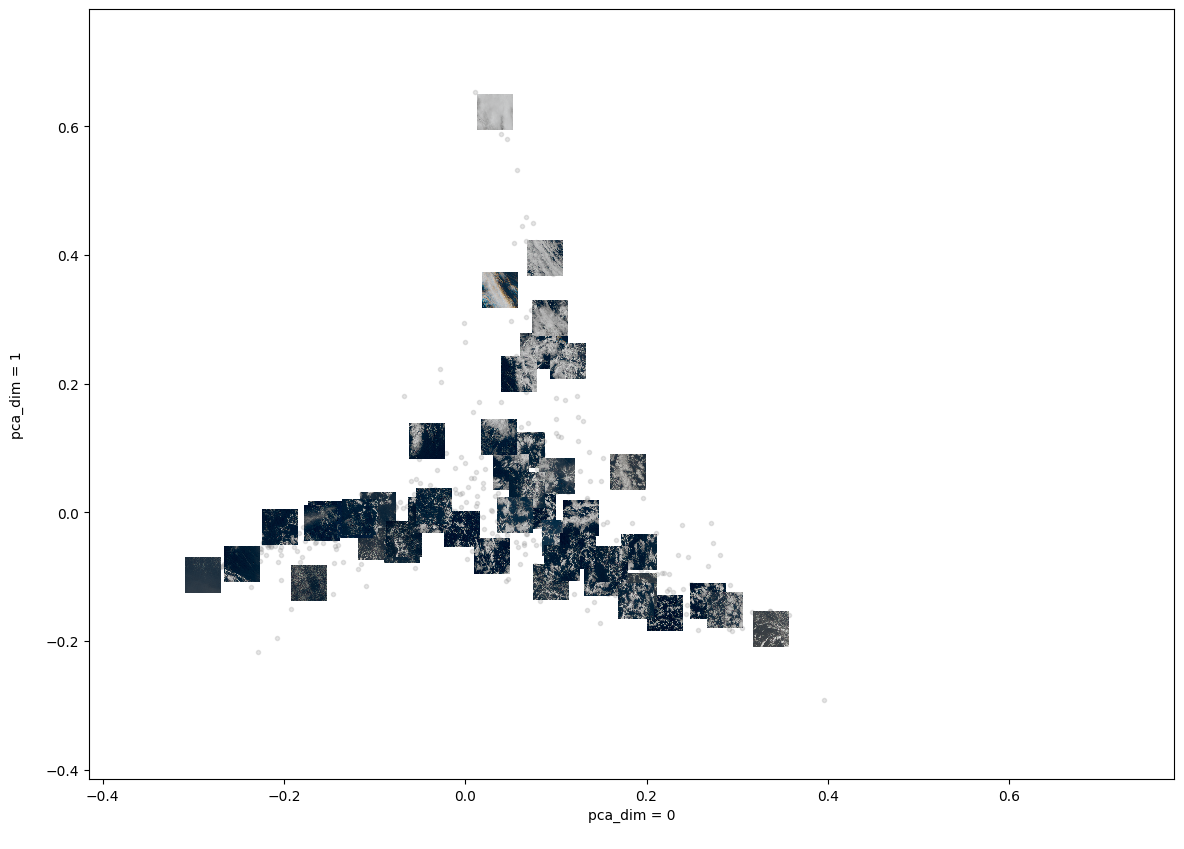

In [10]:
# plot the first two PCA dimensions against each other, annotated with 50 random tiles

fig, ax = plt.subplots(figsize=(14, 10))
x = da_embs_pca.sel(pca_dim=0)
y = da_embs_pca.sel(pca_dim=1)
_ = convml_tt.interpretation.plots.annotated_scatter_plot(
    x, y, points=50, ax=ax, autopos_method=None
)

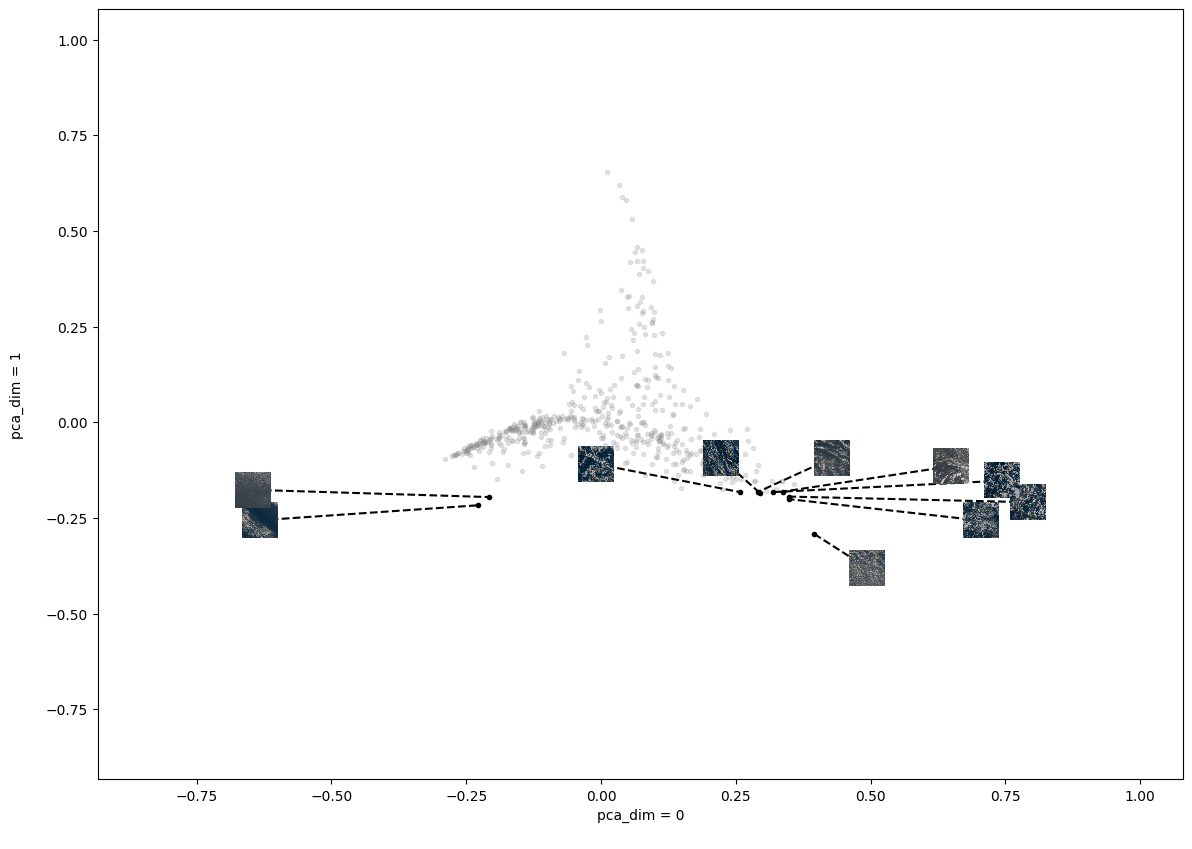

In [11]:
# plot the first two PCA dimensions against each other, annotated with
# 10 tiles with smallest values for the second component

fig, ax = plt.subplots(figsize=(14, 10))


x = da_embs_pca.sel(pca_dim=0)
y = da_embs_pca.sel(pca_dim=1)

da_sorted = da_embs_pca.sortby(da_embs_pca.sel(pca_dim=1))
points = da_sorted.tile_id.values[:10]

_ = convml_tt.interpretation.plots.annotated_scatter_plot(x, y, points=points, ax=ax)

### Questions to look at

1. How many components are needed to retain 50%, 90%, 95%, etc of the variance? How many components should be enough when training the neural network?

2. What do the principle components describe? Is it possible to give a physical intepretation about what each principle components measures about the cloud organisation?

If you have more time you could investigate [alternative dimensionality reduction methods](https://scikit-learn.org/stable/modules/unsupervised_reduction.html) in scikit-learn. How do other models differ to PCA and how would that affect your conclusions above?